In [1]:
import os
import re
import cv2
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import img_to_array

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


# defining the size of the image
SIZE = 64
_img = []
path = '.input/face-mask-lite-dataset/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == 'seed9090.png':
        break
    else:
        img = cv2.imread(path + '/' + i, 1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = (img - 127.5) / 127.5
        imh = img.astype(float)
        _img.append(img_to_array(img))

100%|█████████| 501/501 [00:09<00:00, 51.68it/s]


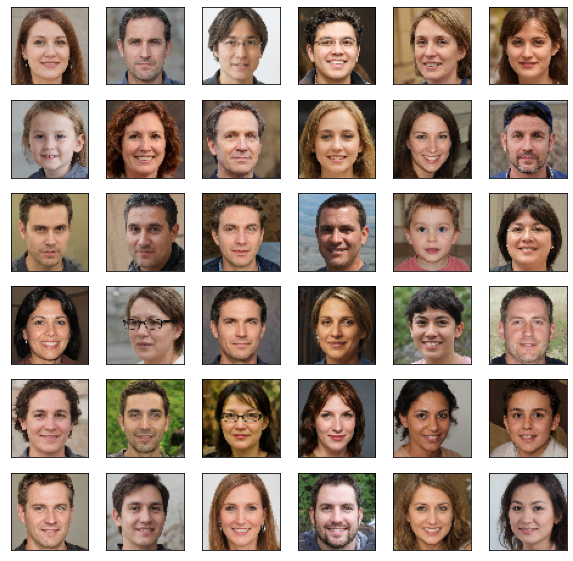

In [3]:
def plot_images(sqr=5):
    plt.figure(figsize=(10, 10))
    plt.title("Real Images", fontsize=35)
    for i in range(sqr * sqr):
        plt.subplot(sqr, sqr, i + 1)
        plt.imshow(_img[i] * 0.5 + 0.5)
        plt.xticks([])
        plt.yticks([])


# to plot images
plot_images(6)

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [5]:
latent_dim = 100


def Generator():
    model = tf.keras.Sequential()
    model.add(
        layers.Dense(SIZE * SIZE * 3, use_bias=False,
                     input_shape=(latent_dim, )))
    model.add(layers.Reshape((SIZE, SIZE, 3)))
    # downsampling
    model.add(
    tf.keras.layers.Conv2D(64,
                           4,
                           strides=1,
                           padding='same',
                           kernel_initializer='he_normal',
                           use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(64,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(128,
                               4,
                               strides=1,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(128,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2D(256,
                               4,
                               strides=1,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(256,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2DTranspose(512,
                                        4,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(512,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))

    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(
        tf.keras.layers.Conv2DTranspose(512,
                                        4,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(
        tf.keras.layers.Conv2DTranspose(512,
                                        4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2DTranspose(256,
                                        4,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(
        tf.keras.layers.Conv2DTranspose(256,
                                        4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(
        tf.keras.layers.Conv2DTranspose(128,
                                        4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(
        tf.keras.layers.Conv2DTranspose(128,
                                        4,
                                        strides=1,
                                        padding='same',
                                        kernel_initializer='he_normal',
                                        use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        tf.keras.layers.Conv2DTranspose(3,
                                        4,
                                        strides=1,
                                        padding='same',
                                        activation='tanh'))

    return model

In [6]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12288)             1228800   
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3072      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        65536     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131072    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       262144    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       5

In [7]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(
    tf.keras.layers.Conv2D(64,
                           4,
                           strides=2,
                           padding='same',
                           kernel_initializer='he_normal',
                           use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
    tf.keras.layers.Conv2D(64,
                           4,
                           strides=2,
                           padding='same',
                           kernel_initializer='he_normal',
                           use_bias=False))
    model.add(
        tf.keras.layers.Conv2D(128,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2D(128,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2D(256,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2D(256,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2D(512,
                               4,
                               strides=2,
                               padding='same',
                               kernel_initializer='he_normal',
                               use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [8]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        3072      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        65536     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)        

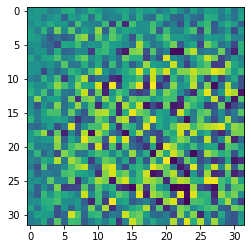

In [9]:
noise = np.random.normal(-1, 1, (1, 100))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

In [10]:
optimizer = tf.keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    return fake_loss + real_loss

In [12]:
def train_steps(images):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    gradient_of_generator = gen_tape.gradient(gen_loss,
                                              generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(
        dis_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(
        zip(gradient_of_generator, generator.trainable_variables))
    optimizer.apply_gradients(
        zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss': gen_loss, 'disc loss': dis_loss}

    return loss

In [13]:
def plot_generated_images(square=5, epochs=0):

    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if (i == square // 2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs),
                          fontsize=32,
                          color='black')
        plt.subplot(square, square, i + 1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0, ...] + 1) / 2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()


Epoch : 1


C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


 Time:7.0
Generator Loss: 1.6477508544921875 Discriminator Loss: 0.21449747681617737

Epoch : 2
 Time:3.0
Generator Loss: 3.134477138519287 Discriminator Loss: 0.04537724331021309

Epoch : 3
 Time:2.0
Generator Loss: 3.996397018432617 Discriminator Loss: 0.019088437780737877

Epoch : 4
 Time:3.0
Generator Loss: 5.320590019226074 Discriminator Loss: 0.00515121640637517

Epoch : 5
 Time:3.0
Generator Loss: 6.10152530670166 Discriminator Loss: 0.00234692869707942


C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


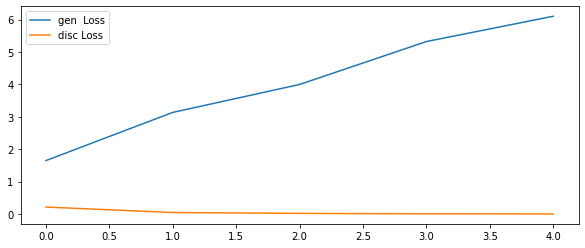

In [14]:
import time

gen_loss, disc = [], []


def train(epochs, dataset):
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)

        print(" Time:{}".format(np.round(time.time() - start), 2))
        print("Generator Loss: {} Discriminator Loss: {}".format(
            loss['gen loss'], loss['disc loss']))
        gen_loss.append(loss['gen loss'].numpy())
        disc.append(loss['disc loss'].numpy())


train(5, dataset)

x = range(len(gen_loss))
figure, ax2 = plt.subplots(1, figsize=(10, 4))
ax2.plot(x, gen_loss, label='gen  Loss')
ax2.plot(x, disc, label='disc Loss')
ax2.legend(loc="best")
figure.show()

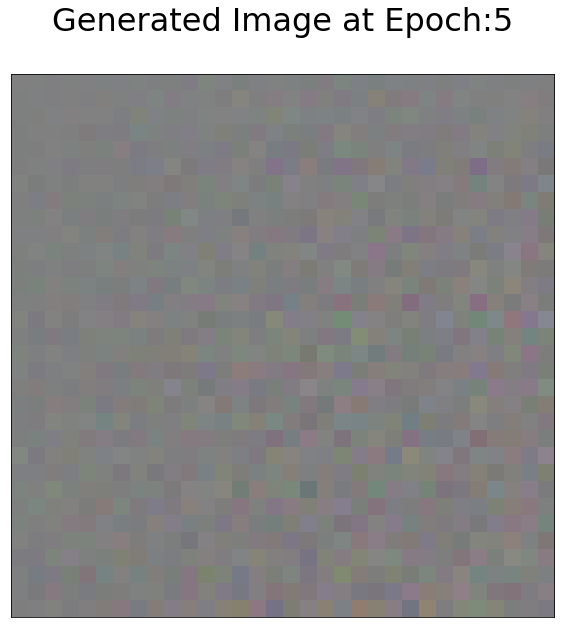

In [15]:
plot_generated_images(1, 5)

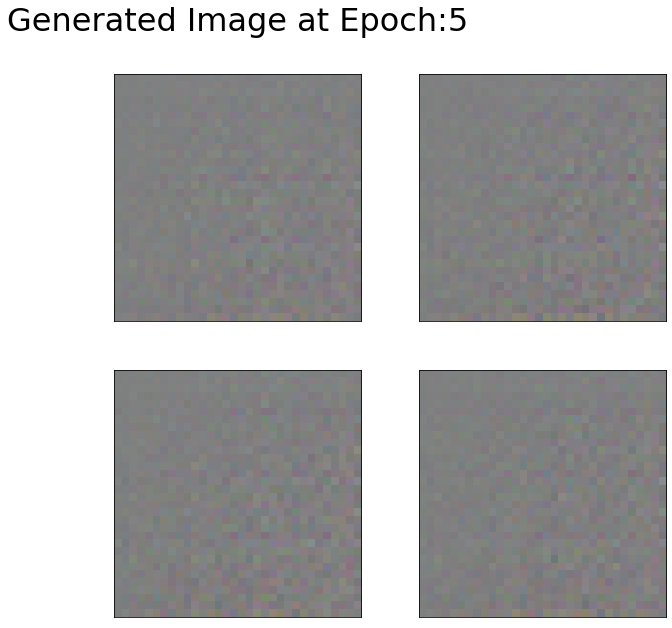

In [16]:
plot_generated_images(2, 5)